# Volume 4: HIV Treatment
    Daniel Perkins
    MATH 439
    1/20/25

In [1]:
import numpy as np
from matplotlib import pyplot as plt

from scipy.integrate import solve_ivp
from scipy.interpolate import CubicSpline

In [2]:
# Define constants used in equations.
a_1, a_2 = 0, 0
b_1, b_2 = 0.02, 0.9
s_1, s_2 = 2, 1.5
mu = 0.002
k = 0.000025    # The paper uses 0.00025, but it's hard to determine which solution actually makes sense.
g = 30
c = 0.007
B_1, B_2 = 14, 1
A_1, A_2 = 250000, 75

constants = a_1, a_2, b_1, b_2, s_1, s_2, mu, k, g, c, B_1, B_2, A_1, A_2

# Define other constants.
T0, V0 = 400, 3
n = 2000
t_f = 50

# Problem 1

Create a function that defines the state equations and returns both equations in
a single array. The function should be able to be passed into `solve_ivp`.

In [8]:
def state_equations(t, y, u_interpolation, constants):
    '''
    Parameters
    ---------------
    t : float
        the time
    y : ndarray (2,)
        the T cell concentration and the virus concentration at time t
    u_interpolation : CubicSpline
                    the values of the control u_interpolation(t) = [u1(t), u2(t)]
    constants : a_1, a_2, b_1, b_2, s_1, s_2, mu, k, g, c, B_1, B_2, A_1, A_2
    
    Returns
    --------------
    y_dot : ndarray (2,)
            the derivative of the T cell concentration and the virus
            concentration at time t
    '''
    # Extract the variables
    a_1, a_2, b_1, b_2, s_1, s_2, mu, k, g, c, B_1, B_2, A_1, A_2 = constants
    T, V = y
    u_1, u_2 = u_interpolation(t)
    
    # Formula 20.1
    T_prime = s_1 - (s_2*V)/(B_1+V) - mu*T - k*V*T + u_1*T
    V_prime = ((g*V)/(B_2+V)) * (1 - u_2) - c*V*T
    
    return np.array([T_prime, V_prime])
    

In [11]:
# You may use the following code to check that your state equations are implemented correctly.
u = lambda _: np.full(2, 1/2)
state = np.ones(2)

state_equations(0, state, u, constants)
# This should result in [2.397975, 7.493].

array([2.397975, 7.493   ])

# Problem 2

Create a function that defines the costate equations and returns both equations
in a single array. The function should be able to be passed into `solve_ivp`.

In [37]:
def costate_equations(t, y, u_interpolation, state_solution, constants):
    '''
    Parameters
    ---------------
    t : float
        the time
    y : ndarray (2,)
        the lambda values at time t 
    u_interpolation : CubicSpline
                    the values of the control u_interpolation(t) = [u1(t), u2(t)]
    state_solution : result of solve_ivp on state_equations with
        dense_output=True, i.e., state_solution.sol(t) = [T(t), V(t)]
    constants : a_1, a_2, b_1, b_2, s_1, s_2, mu, k, g, c, B_1, B_2, A_1, A_2
    
    Returns
    --------------
    y_dot : ndarray (2,)
            the derivative of lambda at time t
    '''
    # Extract the variables
    a_1, a_2, b_1, b_2, s_1, s_2, mu, k, g, c, B_1, B_2, A_1, A_2 = constants
    lam_1, lam_2 = y
    u_1, u_2 = u_interpolation(t)
    T, V = state_solution.sol(t)
    
    # Formula 20.2
    lam_1_prime = -1 + lam_1*(mu + k*V - u_1) + lam_2*c*V
    lam_2_prime = lam_1*(((B_1*s_2)/(B_1+V)**2) + k*T) - lam_2*(((B_2*g*(1-u_2))/(B_2+V)**2) - c*T)
    
    return np.array([lam_1_prime, lam_2_prime])
    
    

In [38]:
# You may use the following code to check that your costate equations are implemented correctly.
u = lambda _: np.full(2, 1/2)
costate = np.ones(2)
class test_state_solution(): sol = lambda self, _: np.ones(2)

costate_equations(0, costate, u, test_state_solution(), constants)
# This should result in [-1.490975, -3.64964167]

array([-1.490975  , -3.64964167])

# Problem 3

Create and run a numerical solver for the HIV two drug model. Plot the solution.

In [70]:
# Initialize state, costate, and u.
state0 = np.array([T0, V0])
costate0 = np.zeros(2)

u = np.zeros((2, n))
u[0], u[1] = b_1, b_2

max_step = 0.5

epsilon = 0.001
test = epsilon + 1

tls = np.linspace(0, t_f, n)
while(test > epsilon):
    oldu = u.copy()
    u_interpolation = CubicSpline(tls, u.T, axis=0)

    # Solve the state equations forward in time.
    state_solution = solve_ivp(state_equations, (0, t_f), state0, 
                            args=(u_interpolation, constants), 
                            t_eval=tls, max_step=max_step, dense_output=True)
        
    # Solve the costate equations backward in time.
    costate_solution = solve_ivp(costate_equations, (t_f, 0), costate0,
                            args=(u_interpolation, state_solution, constants),
                            t_eval=tls[::-1], max_step=max_step, dense_output=True)

    # Solve for u1 and u2.
    T, V = state_solution.y
    lam_1, lam_2 = costate_solution.y[:, ::-1]
    u1 = np.minimum(np.maximum(a_1, (1/(2*A_1)) * (lam_1*T)), b_1)
    u2 = np.minimum(np.maximum(a_2, ((-lam_2)/(2*A_2))*((g*V)/(B_2+V))), b_2)
    
    # Update control u with u1 and u2.
    u[0], u[1] = u1, u2

    # Test for convergence
    test = abs(oldu - u).sum()

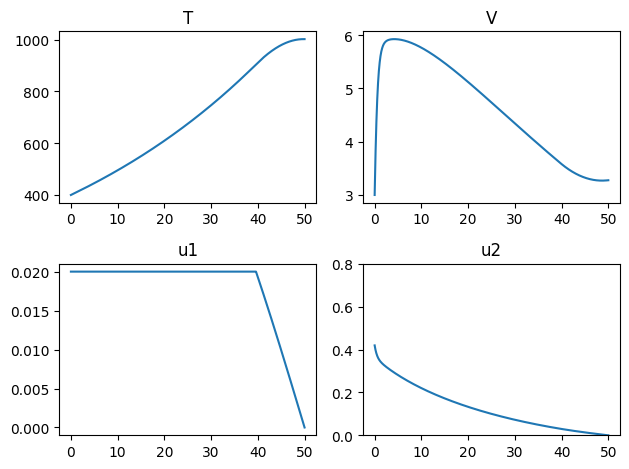

In [74]:
# Plot T
plt.subplot(221)
plt.title("T")
plt.plot(tls, T)

# Plot V
plt.subplot(222)
plt.title("V")
plt.plot(tls, V)

# Plot u1
plt.subplot(223)
plt.title("u1")
plt.plot(tls, u1)

# Plot u2
plt.subplot(224)
plt.ylim(0, 0.8)
plt.title("u2")
plt.plot(tls, u2)

# Show plot
plt.tight_layout()
plt.show()